In [1]:
%cd ../

/home/zulqarnain/algorithm16_skipped/htfatorch


In [2]:
import logging
import numpy as np
import htfa_torch.dtfa as DTFA
import htfa_torch.niidb as niidb
import htfa_torch.utils as utils
import matplotlib.pyplot as plt

/home/zulqarnain/anaconda3/envs/htfatorch/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/zulqarnain/anaconda3/envs/htfatorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/zulqarnain/anaconda3/envs/htfatorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py

In [3]:
import itertools
from torch.nn.functional import softplus
import matplotlib.patches as mpatches
from ordered_set import OrderedSet

In [4]:
import torch

torch.cuda.set_device(0)

In [5]:
%matplotlib inline

In [6]:
scenario_name = 'scenario_3_simplified_tiny'
TRAIN = False

In [7]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [8]:
synthetic_db = niidb.FMriActivationsDb('data/simulated_simplified_data_3_tiny.db')

In [11]:
dtfa = DTFA.DeepTFA(synthetic_db.all(), mask='/home/zulqarnain/fmri_data/simulated_degeneracy_data/wholebrain.nii.gz', num_factors=9, embedding_dim=2)

08/20/2020 19:20:09 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/Scenario_3_tiny/nifti_files/participant_1_video1_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
08/20/2020 19:20:09 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/Scenario_3_tiny/nifti_files/participant_1_video2_low_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
08/20/2020 19:20:09 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/Scenario_3_tiny/nifti_files/participant_1_video3_high_0.nii with mask /home/zulqarnain/fmri_data/simulated_simplified_data_C/wholebrain.nii.gz (zscore=False, smooth=None, zscore_by_rest=False)
08/20/2020 19:20:09 Loading Nifti image /home/zulqarnain/fmri_data/simulated_simplified_data_C/Scenario_3_tiny/nifti_files/participant_1_v

In [12]:
dtfa.num_blocks

16

In [13]:
dtfa.tasks()

OrderedSet(['video1', 'video2', 'video3', 'video4', 'video5', 'video6', 'video7', 'video8'])

In [14]:
dtfa.subjects()

OrderedSet([1, 2])

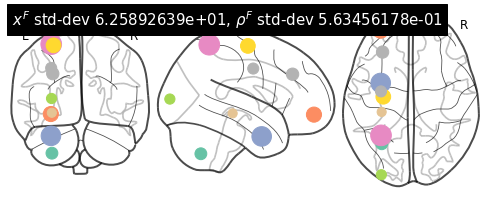

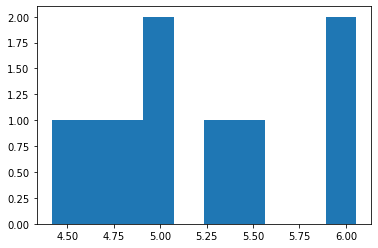

(<nilearn.plotting.displays.OrthoProjector at 0x7f8378f6ce10>,
 tensor([[-29.7135, -62.2112, -50.1080],
         [-30.8796,  56.7644,  -8.9360],
         [-30.7795,   1.7628, -31.8627],
         [-30.4731, -53.3759,  64.6084],
         [-30.1319, -94.8269,   7.4388],
         [-28.0797, -12.7416,  63.3522],
         [-29.8161, -28.7739,  -7.6152],
         [-30.4996,  -7.1323,  39.5266],
         [-28.8377,  34.2676,  33.5576]]),
 tensor([4.9419, 5.4312, 5.9469, 6.0550, 4.6474, 5.3780, 4.4170, 4.8088, 5.0264]))

In [15]:
dtfa.visualize_factor_embedding()

In [16]:
if TRAIN:
    losses = dtfa.train(num_steps=1000, learning_rate={'q': 1e-1, 'p': 1e-3}, log_level=logging.INFO, num_particles=1,
                        batch_size=60, use_cuda=True, checkpoint_steps=500, blocks_batch_size=60, patience=50)
else:
    dtfa.load_state('scenario_3_final_08202020_110442')

In [17]:
if TRAIN:
    utils.plot_losses(losses)

In [18]:
def task_labeler(task):
    return task


def rest_task_labeler(task):
    if task == 'rest':
        return 'Rest'
    else:
        return 'Task'

In [19]:
def subject_labeler(subject):
    return str(subject)

In [20]:
hyperparams = dtfa.variational.hyperparams.state_vardict()
z_s_mu = hyperparams['task']['mu']
z_p_mu = hyperparams['subject_weight']['mu']
tasks = dtfa.tasks()
subjects = dtfa.subjects()
interactions = OrderedSet(list(itertools.product(subjects, tasks)))

In [21]:
subjects[0]

1

In [22]:
dtfa.decoder.interaction_embedding(torch.cat((z_p_mu[1], z_s_mu[0]), dim=-1)).data.numpy()

array([ 0.6069983 ,  0.06623316,  1.6931316 ,  1.0686828 , -0.1696558 ,
        1.2581108 , -0.41390613,  0.0848123 ], dtype=float32)

In [23]:
dtfa.decoder.interaction_embedding(torch.cat((z_p_mu[1], z_s_mu[1]), dim=-1))

tensor([ 0.7148,  0.3861,  2.0397,  0.8438, -0.1312,  1.1541, -0.4134,  0.1431],
       grad_fn=<PreluBackward>)

In [24]:
dtfa.decoder.interaction_embedding(torch.cat((z_p_mu[1], z_s_mu[2]), dim=-1))

tensor([ 1.6868,  1.1018,  4.3161,  0.2447,  0.0543,  1.7507, -0.7812,  0.1712],
       grad_fn=<PreluBackward>)

In [25]:
def stimulus_labeler(stimulus):
    stim = stimulus[-1]
    if int(stim) == 1 or int(stim) == 2:
        return 'State 0'
    elif int(stim) == 3 or int(stim) == 4:
        return 'State 1'
    elif int(stim) == 5 or int(stim) == 6:
        return 'State 2'
    elif int(stim) == 7 or int(stim) == 8:
        return 'State 3'
    else:
        print ('Error')

/home/zulqarnain/algorithm16_skipped/htfatorch/htfa_torch/utils.py:149: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


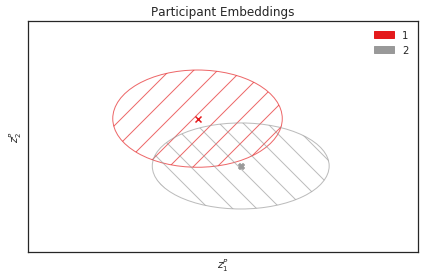

In [26]:
dtfa.scatter_subject_embedding(labeler=subject_labeler, figsize=None, colormap='Set1',
                            filename='subject_norest_subject_embedding' + scenario_name + '.png')

/home/zulqarnain/algorithm16_skipped/htfatorch/htfa_torch/utils.py:149: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


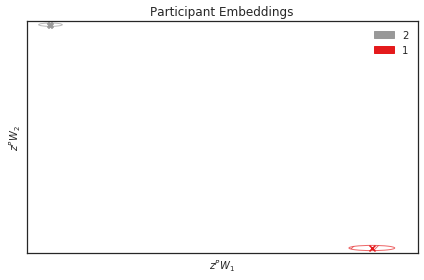

In [27]:
dtfa.scatter_subject_weight_embedding(labeler=subject_labeler, figsize=None, colormap='Set1',
                            filename='subject_norest_subject_weight_embedding' + scenario_name + '.png')

/home/zulqarnain/algorithm16_skipped/htfatorch/htfa_torch/utils.py:149: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


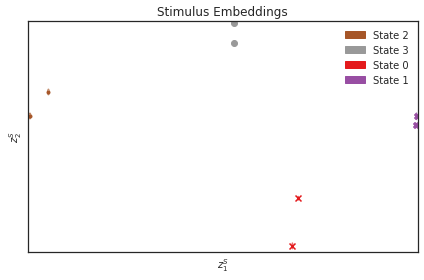

In [28]:
dtfa.scatter_task_embedding(labeler=stimulus_labeler,figsize=None, colormap='Set1',
                            filename='subject_norest_task_embedding' + scenario_name + '.png')

In [38]:
def scatter_interactions_embedding(self, labeler=None, filename='', show=True,
                                   xlims=None, ylims=None, figsize=utils.FIGSIZE,
                                   colormap='Accent', serialize_data=True,
                                   plot_ellipse=True, legend_ordering=None,nstd=3):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]
    
    if filename == '':
        filename = self.common_name() + '_task_embedding.pdf'
    hyperparams = self.variational.hyperparams.state_vardict()
    tasks = self.tasks()
    subjects = self.subjects()
    z_p_mu = hyperparams['subject_weight']['mu'].data
    z_s_mu = hyperparams['task']['mu'].data
    interactions = OrderedSet(list(itertools.product(subjects, tasks)))
    z_ps_mu = np.zeros(shape=(len(interactions),2))
    count = 0
    for p in range (len(subjects)):
        for t in range(len(tasks)):
            joint_embed = torch.cat((z_p_mu[p], z_s_mu[t]), dim=-1)
            interaction_embed = self.decoder.interaction_embedding(
                joint_embed).data
            z_ps_mu[count,:] = self.decoder.interaction_embedding_out(torch.cat((interaction_embed,
                                                                                 joint_embed),dim=-1)).data.numpy()
            count += 1
    embedding_name = 'z^{PS}'

    fig, ax = plt.subplots(facecolor='white', figsize=figsize, frameon=True)
    if xlims is not None:
        ax.set_xlim(xlims)
    if ylims is not None:
        ax.set_ylim(ylims)
    ax.set_xticks([])
    ax.set_yticks([])
    task_colors = ['black','darkgreen','red','blue']
    task_low_embeddings = []
    task_high_embeddings = []

    for i in range(len(z_ps_mu)):
        if stimulus_labeler(interactions[i][1]) == 'State 0':
            edgecolor = task_colors[0]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[0], marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[0], marker='^', s=400, linewidth=4)
            task_low_embeddings.append(z_ps_mu[i,:])
        elif stimulus_labeler(interactions[i][1]) == 'State 1':
            edgecolor = task_colors[1]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 2':
            edgecolor = task_colors[2]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[2],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[2],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 3':
            edgecolor = task_colors[3]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[3],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[3],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 

    ordered_tasks = ['Baseline','Trial A', 'Trial B', 'Trial C']
    single_task_colors = ['darkgreen','red','blue']
    manual_legend = [mpatches.Patch(color=c,label=t) for (c,t) in zip(task_colors,ordered_tasks)]
    temp_dict = {key:[] for key in subjects}
    linestyle = ['solid','dashed']

    
    if filename is not None:
        fig.savefig(filename)
    if show:
        fig.show()
        
    return task_low_embeddings,task_high_embeddings


In [39]:
def interactions_labeler(subject,task):
    
    return task_labeler(task) + subject_labeler(subject)

/home/zulqarnain/anaconda3/envs/htfatorch/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


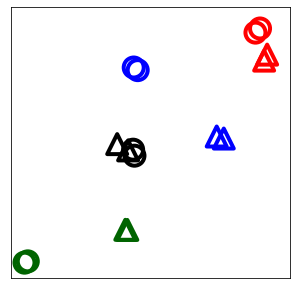

In [40]:
task_low_embeddings,task_high_embeddings= scatter_interactions_embedding(dtfa,labeler=interactions_labeler,
                               filename='subject_norest_interaction_embedding' + scenario_name + '.png',
                               plot_ellipse=True,colormap='tab20',figsize=(5,5),nstd=3)